# b2__generation.py

In [2]:
import networkx as nx
import numpy as np 
import random
import math 
from numpy.linalg import matrix_rank
from scipy import linalg

def get_adj(g):
  adj = np.zeros((len(g.nodes()),len(g.nodes())))
  #print(g.edges())
  for e in np.array(g.edges()):
    adj[e[0],e[1]] = 1
    adj[e[1],e[0]] = 1
  return adj


def getCycles(A,max_len=math.inf):
  ''''A = adj matrix'''
  ''''p_max_len = lenght if max cycles wanted, inf default for all cycles'''
  G = nx.DiGraph(A)
  cycles = nx.simple_cycles(G)
  final = []
  for elem in cycles:
    if sorted(elem) not in [sorted(x) for x in final]:
      final.append(elem)
  final = [c for c in final if len(c)>=3 and len(c)<= max_len]
  final.sort(key=len)
  return final


def create_B1(A):
  G = nx.Graph(A) #nx.from_numpy_matrix(A) #
  E_list = list(G.edges) 
  B1 = np.zeros([len(G.nodes),len(E_list)])
  for n in G.nodes: 
    for e in E_list:
      if n==e[0]:
        B1[n,E_list.index(e)] = 1
      elif n==e[1]:
        B1[n,E_list.index(e)] = -1 
      else:
        B1[n,E_list.index(e)] = 0
  return B1

def create_B2(A,p_max_len=math.inf):
  ''''A = adj matrix'''
  ''''p_max_len = lenght if max cycles wanted, inf default for all cycles'''
  G = nx.Graph(A) # nx.from_numpy_matrix(A) #
  E_list = list(G.edges)
  All_P = getCycles(A,p_max_len)
  cycles = [x + [x[0]] for x in All_P]
  P_list = []
  for c in cycles:
    p = []
    for i in range(len(c)-1):
      p.append([c[i],c[i+1]])
    P_list.append(p)
  B2 = np.zeros([len(E_list),len(P_list)])
  for e in E_list:
    for p in P_list:
      if list(e) in p:
        B2[E_list.index(e),P_list.index(p)] = 1
      elif [e[1],e[0]] in p:
        B2[E_list.index(e),P_list.index(p)] = -1
      else:
        B2[E_list.index(e),P_list.index(p)] = 0
  qr = linalg.qr(B2,pivoting=True)
  B2 = B2[: ,sorted(qr[2])[:matrix_rank(B2)]]
  return B2

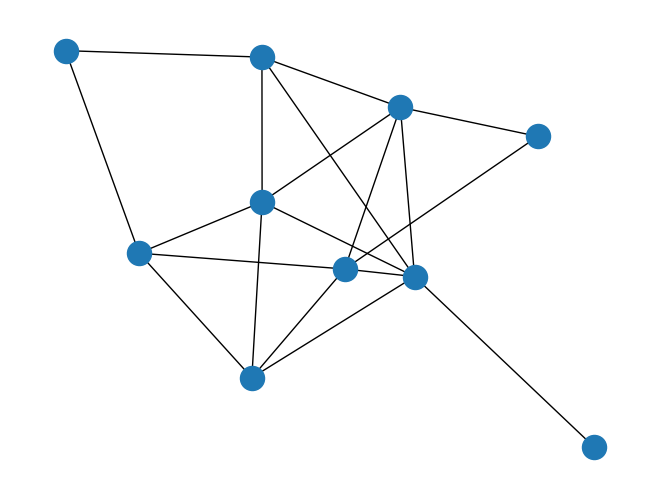

In [58]:
#Example
n = 10
p = .5
seed = 0
G = nx.erdos_renyi_graph(n, p, seed)
nx.draw(G)
A = get_adj(G)
B1 = create_B1(A)
B2 = create_B2(A,4)


In [59]:
G.number_of_edges()

19

# Init param_dic.m

In [76]:
import numpy.linalg as la

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1)
Lu = np.matmul(B2, np.transpose(B2))
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]
_ ,U = la.eig(L)

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
gamma = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10


# create_ground_truth.m

In [157]:
# # prova

# lambdas, _ = la.eigh(L)
# lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
# lambda_max = np.max(lambdas)
# lambda_min = np.min(lambdas)
# Lk = np.array([la.matrix_power(L, i) for i in range(1, k + 1)])
# lambda_max_k = lambda_max ** np.arange(1, k + 2)
# lambda_min_k = lambda_min ** np.arange(1, k + 2)
# lambda_min_k.shape

# def compute_Lk_and_lambdak(L, K, separated=False):
#     lambdas, _ = la.eigh(L)
#     lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
#     lambda_max = np.max(lambdas)
#     lambda_min = np.min(lambdas)
#     Lk = np.array([la.matrix_power(L, i) for i in range(1, K + 1)])
#     # for the "separated" implementation we need a different dimensionality
#     if separated:
#         lambda_max_k = lambda_max ** np.arange(1, K + 1)
#         lambda_min_k = lambda_min ** np.arange(1, K + 1)
#     else:
#         lambda_max_k = lambda_max ** np.arange(1, K + 2)
#         lambda_min_k = lambda_min ** np.arange(1, K + 2)
#     return Lk, lambda_max_k, lambda_min_k

# def generate_coeffs(*arrays):
#     """ 
#     lambdamax1 is for Ld (lower laplacian) and lambdamax2 is for Lu (upper)
#     Select ad hoc parameters for synthetic data generation, randomly over
#     an interval dependent on the max eigenvalues of the Laplacian(s)
#     """

#     # if passing four arguments (two for upper and two for lower laplacian eigevals)
#     # it means that you are using dictionary_type="separated"
#     if len(arrays)==2:
#         lambda_max_k, lambda_min_k = arrays
#         K = lambda_max_k.shape[0]
#         h = 10 / np.max(lambda_max_k) * np.random.rand(s, K)
#         # For later sanity check in optimization phase 
#         tmp_max_vec = h @ lambda_max_k # parallelize the code with simple matrix multiplications
#         tmp_min_vec = h @ lambda_min_k
#         c = np.max(tmp_max_vec)
#         tmp_sum_max = np.sum(tmp_max_vec)
#         tmp_sum_min = np.sum(tmp_min_vec)

#         Delta_min = c - tmp_sum_min
#         Delta_max = tmp_sum_max - c
#         epsilon = (Delta_max - Delta_min) * np.random.rand() + Delta_min

#     elif len(arrays)==4:
#         lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k
#         K = lambda_max_u_k.shape[0]
#         hI = 10 / np.max(lambda_max_d_k) * np.random.rand(s, K)
#         hS = 10 / np.max(lambda_max_u_k) * np.random.rand(s, K)
#         hH = 10 / np.min([np.max(lambda_max_u_k), np.max(lambda_max_d_k)]) * np.random.rand(s, 1)
#         h = [hS, hI, hH]
#         # For later sanity check in optimization phase
#         tmp_max_vec_S = hS @ lambda_max_u_k
#         tmp_min_vec_S = hS @ lambda_min_u_k
#         tmp_max_vec_I = hI @ lambda_max_d_k
#         tmp_min_vec_I = hI @ lambda_min_d_k
#         c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
#         tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
#         tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
#         Delta_min = c - tmp_sum_min
#         Delta_max = tmp_sum_max - c
#         epsilon = np.max([Delta_min, Delta_max])
#     else:
#         raise ValueError("Function accepts either 2 or 4 arrays! In case of 4 arrays are provided,\
#                           the first 2 refer to upper laplacian and the other two to lower laplacian.")
#     return h, c, epsilon

# def generate_dictionary(h, *matrices):
#     D = []
#     # Always check if upper and lower Laplacians are separately provided
#     if len(matrices)==1:
#         Lk = matrices
#         n = Lk.shape[-1]
#         # iterate over each kernel dimension
#         for i in range(0,s):
#             # Replicate formula (8) of the paper for the i-th sub-dictionary
#             tmp = np.sum(h[i]*Lk, axis=0) + hid*np.eye(n,n)
#             D.append(tmp)
#     elif len(matrices)==2:
#         Luk , Ldk = matrices
#         n = Luk.shape[-1]
#         # iterate over each kernel dimension
#         for i in range(0,s):
#             # Replicate formula (8) of the paper for the i-th sub-dictionary
#             hu = h[0][i].reshape(k,1,1)
#             hd = h[1][i].reshape(k,1,1)
#             hid = h[2][i]
#             tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
#             D.append(tmp)
#     else:
#         raise ValueError("Function accepts one vector and either 1 or 2 matrices.")
#     return D


# Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, k, separated=True)
# Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, k, separated=True)

# h, c, epsilon = generate_coeffs(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)

# D = generate_dictionary(h, Luk, Ldk)

In [274]:
import numpy as np
import numpy.linalg as la
import pandas as pd

def create_ground_truth(Lu, Ld, m_train, m_test, s, K, K0, dictionary_type, sparsity_mode):

    def compute_Lk_and_lambdak(L, K, separated=False):
        lambdas, _ = la.eigh(L)
        lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
        lambda_max = np.max(lambdas)
        lambda_min = np.min(lambdas)
        Lk = np.array([la.matrix_power(L, i) for i in range(1, K + 1)])
        # for the "separated" implementation we need a different dimensionality
        if separated:
            lambda_max_k = lambda_max ** np.arange(1, K + 1)
            lambda_min_k = lambda_min ** np.arange(1, K + 1)
        else:
            lambda_max_k = lambda_max ** np.arange(1, K + 2)
            lambda_min_k = lambda_min ** np.arange(1, K + 2)
        return Lk, lambda_max_k, lambda_min_k

    def generate_coeffs(*arrays):
        """ 
        Select ad hoc parameters for synthetic data generation, randomly over
        an interval dependent on the max eigenvalues of the Laplacian(s)
        """

        # if passing four arguments (two for upper and two for lower laplacian eigevals)
        # it means that you are using dictionary_type="separated"
        if len(arrays)==2:
            lambda_max_k, lambda_min_k = arrays
            K = lambda_max_k.shape[0]
            h = 10 / np.max(lambda_max_k) * np.random.rand(s, K)
            # For later sanity check in optimization phase 
            tmp_max_vec = h @ lambda_max_k # parallelize the code with simple matrix multiplications
            tmp_min_vec = h @ lambda_min_k
            c = np.max(tmp_max_vec)
            tmp_sum_max = np.sum(tmp_max_vec)
            tmp_sum_min = np.sum(tmp_min_vec)

            Delta_min = c - tmp_sum_min
            Delta_max = tmp_sum_max - c
            epsilon = (Delta_max - Delta_min) * np.random.rand() + Delta_min

        elif len(arrays)==4:
            lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k
            K = lambda_max_u_k.shape[0]
            hI = 10 / np.max(lambda_max_d_k) * np.random.rand(s, K)
            hS = 10 / np.max(lambda_max_u_k) * np.random.rand(s, K)
            hH = 10 / np.min([np.max(lambda_max_u_k), np.max(lambda_max_d_k)]) * np.random.rand(s, 1)
            h = [hS, hI, hH]
            # For later sanity check in optimization phase
            tmp_max_vec_S = hS @ lambda_max_u_k
            tmp_min_vec_S = hS @ lambda_min_u_k
            tmp_max_vec_I = hI @ lambda_max_d_k
            tmp_min_vec_I = hI @ lambda_min_d_k
            c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
            tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
            tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
            Delta_min = c - tmp_sum_min
            Delta_max = tmp_sum_max - c
            epsilon = np.max([Delta_min, Delta_max])
        else:
            raise ValueError("Function accepts either 2 or 4 arrays! In case of 4 arrays are provided,\
                            the first 2 refer to upper laplacian and the other two to lower laplacian.")
        return h, c, epsilon

    def generate_dictionary(h, *matrices):
        D = []
        # Always check if upper and lower Laplacians are separately provided
        if len(matrices)==1:
            Lk = matrices
            n = Lk.shape[-1]
            # iterate over each kernel dimension
            for i in range(0,s):
                # Replicate formula (8) of the paper for the i-th sub-dictionary
                tmp = np.sum(h[i]*Lk, axis=0) + hid*np.eye(n,n)
                D.append(tmp)
        elif len(matrices)==2:
            Luk , Ldk = matrices
            n = Luk.shape[-1]
            # iterate over each kernel dimension
            for i in range(0,s):
                # Replicate formula (8) of the paper for the i-th sub-dictionary
                hu = h[0][i].reshape(k,1,1)
                hd = h[1][i].reshape(k,1,1)
                hid = h[2][i]
                tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
                D.append(tmp)
        else:
            raise ValueError("Function accepts one vector and either 1 or 2 matrices.")
        D = np.array(D).reshape(n, n*s)
        return D

    # Joint Dictionary Model
    if dictionary_type == "joint":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
        h, c, epsilon = generate_coeffs(lambda_max_k, lambda_min_k)
        D = generate_dictionary(h, Lk)

    # Edge Laplacian Dictionary Model
    elif dictionary_type == "edge_laplacian":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
        h, c, epsilon = generate_coeffs(lambda_max_k, lambda_min_k)
        D = generate_dictionary(h, Lk)

    # Separated Dictionary Model
    elif dictionary_type == "separated":
        Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, k, separated=True)
        Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, k, separated=True)
        h, c, epsilon = generate_coeffs(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)
        D = generate_dictionary(h, Luk, Ldk)

    # Signal Generation
    def create_column_vec(row):
        tmp = np.zeros(n*s)
        tmp[row['idxs']]=row['non_zero_coeff']
        return tmp
    
    m_total = m_train + m_test
    tmp = pd.DataFrame()
    # Determine the sparsity for each column based on sparsity_mode
    if sparsity_mode == "max":
        tmp_K0 = np.random.choice(K0, size=(m_train + m_test), replace=True)
    else:
        tmp_K0 = np.full((m_train + m_test,), K0)
    # sparsity coefficient for each column
    tmp['K0'] = tmp_K0
    # for each column get K0 indexes
    tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
    # for each of the K0 row indexes in each column, sample K0 values
    tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
    # create the column vectors with the desired characteristics
    tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x), axis=1)
    # finally derive the sparse signal representation matrix
    X = np.column_stack(tmp['column_vec'].values)

    all_data = D @ X
    X_train = X[:, :m_train]
    X_test = X[:, m_train:]
    train_Y = all_data[:, :m_train]
    test_Y = all_data[:, m_train:]

    return D, h, train_Y, test_Y, epsilon, c, X_train, X_test



In [275]:
D, h, train_Y, test_Y, epsilon, c, X_train, X_test = create_ground_truth(Lu,
                                                                         Ld,
                                                                         m_train,
                                                                         m_test, 
                                                                         s, 
                                                                         k, 
                                                                         K0_coll[0], 
                                                                         dictionary_type, 
                                                                         sparsity_mode)